In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
random.seed(5)
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal,stats
import os
import h5py

In [2]:
from utils import ReadDatasets

In [3]:
transients, target_spectrum, ppm, fs, tacq, larmorfreq = ReadDatasets.read_h5_complete('../Dados_MRS-20240506T181721Z-001/Dados_MRS/train/g4_s01_random_7.h5')

In [4]:
transients.shape

(4096, 2, 40)

In [5]:
def get_normalized_spgram(
    fid, fs, larmorfreq, linear_shift, window_size, hop_size, window, nfft=None,SFT=None
):

    noverlap = window_size - hop_size
    if not signal.check_NOLA(window, window_size, noverlap):
        raise ValueError(
            "signal windowing fails Non-zero Overlap Add (NOLA) criterion; "
            "STFT not invertible"
        )
    if nfft == None:
        nfft = window_size

    if SFT == None:
        SFT = signal.ShortTimeFFT(
            win=window,
            hop=hop_size,
            fs=fs,
            mfft=nfft,
            scale_to="magnitude",
            fft_mode="centered",
        )
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fid.shape[0])

    stft_coefficients = SFT.stft(fid)
    f = np.linspace(f_lo, f_hi, nfft)
    t = np.linspace(t_lo, t_hi, stft_coefficients.shape[1])
    ppm = linear_shift + f / larmorfreq

    zero_idx = np.abs(t - 0.0).argmin()
    one_idx = np.abs(t - 1.0).argmin()
    t = t[zero_idx:one_idx]
    stft_coefficients = stft_coefficients[:, zero_idx:one_idx]

    # opt 1: Gab
    # stft_coefficients_ordered = np.flip(stft_coefficients, axis=0)
    # stft_coefficients_onesided = stft_coefficients_ordered[(ppm >= 0), :]
    # opt 2:
    #stft_coefficients_onesided = stft_coefficients[(ppm >= 0), :]
    #stft_coefficients_onesided = np.flip(stft_coefficients_onesided, axis=0)
    # opt 3:
    # stft_coefficients_onesided = np.flip(stft_coefficients, axis=0)
    #stft_coefficients_onesided_norm = stft_coefficients_onesided / (
    #    np.max(np.abs(stft_coefficients_onesided))
    stft_coefficients = stft_coefficients/(np.max(np.abs(stft_coefficients)))
    #)

    return stft_coefficients, f, ppm, t

In [29]:
spg,f_spgm,ppm_spgm,t_spgm = get_normalized_spgram(fid=np.mean(transients[:,1,:]-transients[:,0,:],axis=1), fs=fs, larmorfreq=larmorfreq, linear_shift=4.65, window_size=256, hop_size=12, window=signal.windows.hann(256,sym=True))

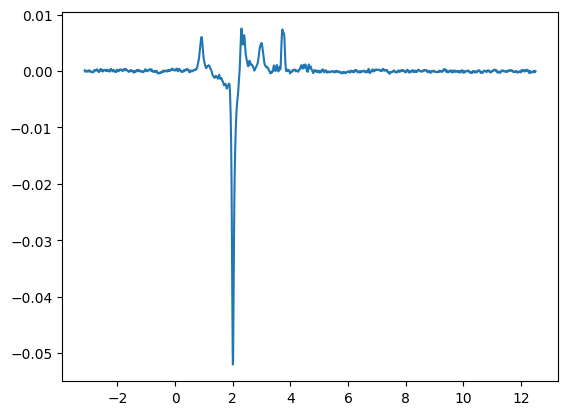

In [10]:
plt.plot(ppm,target_spectrum)

In [13]:
spectrum = np.fft.fftshift(np.fft.fft(np.mean(transients[:,1,:]-transients[:,0,:],axis=1),n=4096))
freq_spectrum = np.fft.fftshift(np.fft.fftfreq(4096, d = 1/fs))
ppm_spectrum = 4.65 + freq_spectrum/larmorfreq

(-2.0, 12.0)

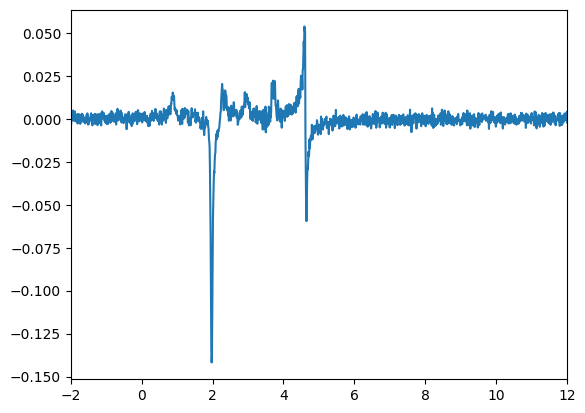

In [16]:
plt.plot(np.flip(ppm_spectrum),np.real(spectrum))
plt.xlim(-2,12)

In [17]:
ppm_spectrum

array([-14.92492977, -14.9153717 , -14.90581363, ...,  24.19625556,
        24.20581363,  24.2153717 ])

In [19]:
ppm_spgm

array([-14.92492977, -14.77200063, -14.6190715 , -14.46614236,
       -14.31321322, -14.16028408, -14.00735494, -13.8544258 ,
       -13.70149666, -13.54856752, -13.39563839, -13.24270925,
       -13.08978011, -12.93685097, -12.78392183, -12.63099269,
       -12.47806355, -12.32513441, -12.17220527, -12.01927614,
       -11.866347  , -11.71341786, -11.56048872, -11.40755958,
       -11.25463044, -11.1017013 , -10.94877216, -10.79584302,
       -10.64291389, -10.48998475, -10.33705561, -10.18412647,
       -10.03119733,  -9.87826819,  -9.72533905,  -9.57240991,
        -9.41948077,  -9.26655164,  -9.1136225 ,  -8.96069336,
        -8.80776422,  -8.65483508,  -8.50190594,  -8.3489768 ,
        -8.19604766,  -8.04311853,  -7.89018939,  -7.73726025,
        -7.58433111,  -7.43140197,  -7.27847283,  -7.12554369,
        -6.97261455,  -6.81968541,  -6.66675628,  -6.51382714,
        -6.360898  ,  -6.20796886,  -6.05503972,  -5.90211058,
        -5.74918144,  -5.5962523 ,  -5.44332316,  -5.29

In [8]:
spg.shape

(256, 351)

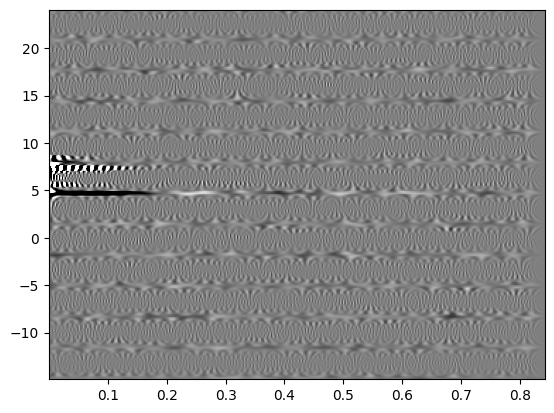

In [30]:
plt.imshow(np.real(spg[:,:]),cmap='gray',vmin=-0.04,vmax=0.04,aspect='auto', origin='lower',
           extent=(t_spgm[0],t_spgm[-1],ppm_spgm[0],ppm_spgm[-1]))

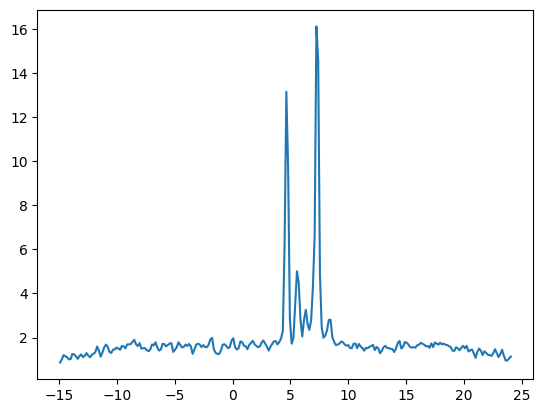

In [32]:
plt.plot(ppm_spgm,np.sum(np.abs(np.real(spg)),axis=1))

In [ ]:
class DatasetSpgramRealData(Dataset):
    def __init__(
        self,
        path_data,
        start,
        end,
        augment,
        fs=None,
        larmorfreq=None,
        linear_shift=None,
        hop_size=None,
        window_size=None,
        window=None,
    ):

        self.path_data = path_data
        self.start_pos = start
        self.end_pos = end
        self.augment = augment
        self.get_item_first_time = True

        with h5py.File(self.path_data) as hf:
            fids = hf["ground_truth_fids"][()][:1]
            ppm = hf["ppm"][()][:1]
            t = hf["t"][()][:1]

        if fs == None:
            dwelltime = t[0, 1] - t[0, 0]
            self.fs = 1 / dwelltime
        else:
            self.fs = fs

        if larmorfreq == None or linear_shift == None:
            a_inv, b = get_Hz_ppm_conversion(
                gt_fids=fids, dwelltime=1 / self.fs, ppm=ppm
            )
        if larmorfreq == None and linear_shift == None:
            self.larmorfreq = a_inv
            self.linear_shift = b
        elif larmorfreq == None and linear_shift != None:
            self.larmorfreq = a_inv
            self.linear_shift = linear_shift
        elif larmorfreq != None and linear_shift == None:
            self.larmorfreq = larmorfreq
            self.linear_shift = b
        else:
            self.larmorfreq = larmorfreq
            self.linear_shift = linear_shift

        if hop_size is not None and window_size is not None and window is not None:
            if window.shape[0] == window_size:
                self.SFT = ShortTimeFFT(
                    win=window,
                    hop=hop_size,
                    fs=self.fs,
                    mfft=window_size,
                    scale_to="magnitude",
                    fft_mode="centered",
                )
                self.hop_size = hop_size
                self.window_size = window_size
                self.window = window
            else:
                self.SFT = None
                self.hop_size = None
                self.window_size = None
                self.window = None
        else:
            self.SFT = None
            self.hop_size = None
            self.window_size = None
            self.window = None

        if self.augment == True:
            self.idx_data = np.empty(100 * (self.end_pos - self.start_pos), dtype="int")
            for i in range(self.start_pos, self.end_pos):
                for j in range(100):
                    self.idx_data[100 * i + j] = i

        else:
            self.idx_data = np.arange(self.start_pos, self.end_pos)

    def __len__(self) -> int:
        return self.idx_data.shape[0]

    def __getitem__(
        self, idx: int
    ) -> (torch.Tensor, torch.Tensor, torch.Tensor, float, str):

        filename = self.path_data
        idx_in_file = self.idx_data[idx]
        with h5py.File(self.path_data) as hf:
            fid = hf["ground_truth_fids"][()][idx_in_file : idx_in_file + 1]
            ppm = hf["ppm"][()][idx_in_file : idx_in_file + 1]
            t = hf["t"][()][idx_in_file : idx_in_file + 1]

        transientmkr = TransientMaker(fids=fid, t=t, n_transients=40)
        transientmkr.add_random_amplitude_noise(
            noise_level_base=6, noise_level_scan_var=2
        )
        aug_fids = transientmkr.fids

        spectrogram1 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 0:14],
            fid_on=aug_fids[0, :, 1, 0:14],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram2 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 14:27],
            fid_on=aug_fids[0, :, 1, 14:27],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram3 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 27:40],
            fid_on=aug_fids[0, :, 1, 27:40],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        if self.get_item_first_time == True:
            print("Generating Spectrograms of size: ", spectrogram1.shape)

        spectrogram1 = zero_padding(spectrogram1)
        spectrogram1 = spectrogram1[np.newaxis, ...]
        if self.get_item_first_time == True:
            print("Zero padded to shape: ", spectrogram1.shape)
            self.get_item_first_time = False
        spectrogram1 = torch.from_numpy(np.real(spectrogram1))

        spectrogram2 = zero_padding(spectrogram2)
        spectrogram2 = spectrogram2[np.newaxis, ...]
        spectrogram2 = torch.from_numpy(np.real(spectrogram2))

        spectrogram3 = zero_padding(spectrogram3)
        spectrogram3 = spectrogram3[np.newaxis, ...]
        spectrogram3 = torch.from_numpy(np.real(spectrogram3))
        three_channels_spectrogram = torch.concat(
            [spectrogram1, spectrogram2, spectrogram3]
        )

        spectra_gt_fid = np.fft.fftshift(
            np.fft.fft(fid[0, :, :], n=fid.shape[1], axis=0), axes=0
        )
        spectra_gt_diff = spectra_gt_fid[:, 1] - spectra_gt_fid[:, 0]
        constant_factor = np.max(np.abs(spectra_gt_diff))
        spectra_norm = spectra_gt_diff / constant_factor
        spectra_reordered = np.flip(np.real(spectra_norm))
        target_spectrum = torch.from_numpy(spectra_reordered.copy())

        freq = np.flip(np.fft.fftshift(np.fft.fftfreq(fid.shape[1], d=1 / self.fs)))
        ppm_np = self.linear_shift + freq / self.larmorfreq
        ppm = torch.from_numpy(ppm_np)

        return (
            three_channels_spectrogram.type(torch.FloatTensor),
            target_spectrum.type(torch.FloatTensor),
            ppm,
            constant_factor,
            filename,
        )
